In [309]:
import re, nltk
import cleantext as ct
import pandas as pd
from itertools import chain
from nltk.corpus import stopwords
from nltk import regexp_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [310]:
def tokenize(string):
    return regexp_tokenize(string, pattern=r"[^\w\d\-''_<>]", gaps=True)

In [311]:
def stem(lst):
  stemmer = nltk.SnowballStemmer(language="english", ignore_stopwords=True)
  stem_words = []
  for token in lst:
    x = stemmer.stem(token)
    stem_words.append(x)
  return stem_words

In [312]:
def remove_stopwords(lst):
  for token in lst:
    stop_words = stopwords.words('english')
    filteredInput = []
    
    for token in lst:
      if token not in stop_words:
        filteredInput.append(token)
        
    return filteredInput

In [313]:
def cleaning(csv):
  data = csv
  df = pd.read_csv(data)
  # counter = 0
  
  for i in range(len(df["content"])):
    # # rename fake-like types to just fake for simplicity
    # if df.loc[i, 'type'] in ["unreliable", "fake", "conspiracy", "junksci"]:
    #   df.loc[i, 'type'] = "fake"
    # elif df.loc[i, 'type'] != 'reliable':
    #   df = df.drop(i)
    #   continue
    value = df.loc[i, "content"]
    value = ct.clean(value, lower=True, no_line_breaks=True, no_numbers=True, no_emails=True, no_urls=True, replace_with_number="<NUM>")
    value = tokenize(value)
    value = remove_stopwords(value)
    value = stem(value)
    df.loc[i, "content"] = ' '.join(map(str,value))
  # df.reset_index(drop=True)
  return df

def cleaning_without_stem_and_removing_stopwords(csv):
  data = csv
  df = pd.read_csv(data)
  # counter = 0
  
  for i in range(len(df["content"])):
    # # rename fake-like types to just fake for simplicity
    # if df.loc[i, 'type'] in ["unreliable", "fake", "conspiracy", "junksci"]:
    #   df.loc[i, 'type'] = "fake"
    # elif df.loc[i, 'type'] != 'reliable':
    #   df = df.drop(i)
    #   continue
    value = df.loc[i, "content"]
    value = ct.clean(value, lower=True, no_line_breaks=True, no_numbers=True, no_emails=True, no_urls=True, replace_with_number="<NUM>")
    value = tokenize(value)
    df.loc[i, "content"] = ' '.join(map(str,value))
  # df.reset_index(drop=True)
  return df

In [314]:
def run():
  df = cleaning("news_sample.csv")
  df.to_csv("cleaned_news_sample.csv")
run()

## Libraries Brugt
### pandas
Converter csv til DataFrame, som kan bruges til at manipulere dataen inde i csv filen nemt
### nltk
Har indbygget pakker til at tokenize text og fjerne stopwords
### cleantext
Renser texten

Stats for Fake:
Average amount of numbers per article:  5.335483870967742
Average Amount of URLs: 0.025806451612903226
Average amount of dates: 0.03225806451612903


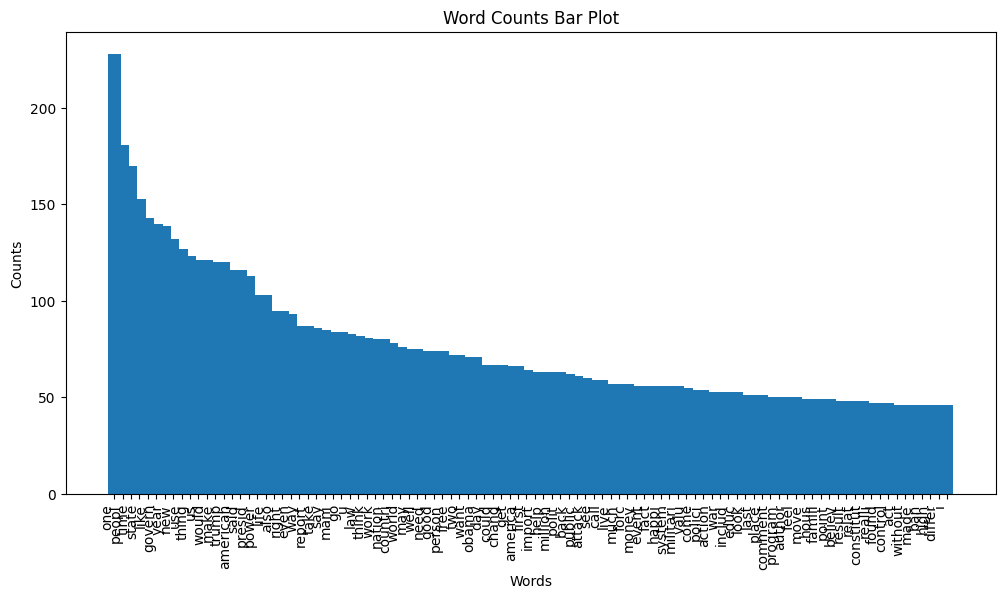

<Figure size 1000x600 with 0 Axes>

Stats for Non-Fake:
Average amount of numbers per article:  16.326315789473686
Average Amount of URLs: 2.5157894736842104
Average amount of dates: 0.23157894736842105


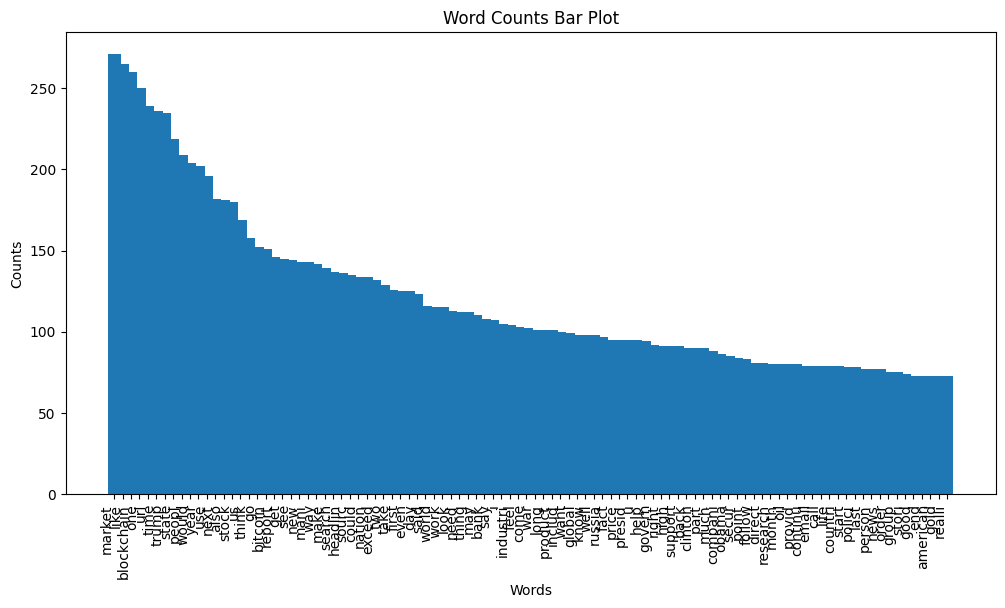

<Figure size 1000x600 with 0 Axes>

In [347]:
def analyze_data(csv):
  df = pd.read_csv(csv)
  
  urlsInReliable = 0
  urlsInFake = 0
  datesInFake = 0
  datesInReliable = 0
  numInFake = 0
  numInReliable = 0
  isFake = 0
  isReliable = 0
  FakeTypeCounter = 0
  NonFakeTypeCounter = 0
  
  df = df.filter(items=["type", "content"])

  dictionaryFake = dict()
  dictionaryReliable = dict()
  for col, row in df.iterrows():
    isFake = 0
    isReliable = 0
    if (row["type"] == "fake"):
      FakeTypeCounter += 1
      isFake += 1
    else:
      NonFakeTypeCounter += 1
      isReliable += 1
    
    for word in row["content"].split():
      urlsInFake += int("<url>" == word) * isFake
      urlsInReliable += int("<url>" == word) * isReliable
      
      datesInFake += int("<date>" == word) * isFake
      datesInReliable += int("<date>" == word) * isReliable
      
      numInFake += int("<num>" == word) * isFake
      numInReliable += int("<num>" == word) * isReliable
    
    
    pattern = re.compile(r"\w+")
    lst = re.findall(pattern, row["content"])
    
    for word in lst:
      if isFake:
        if not dict(dictionaryFake).get(word):
          dictionaryFake[word] = 1
        else:
          dictionaryFake[word] += 1
      else:
        if not dict(dictionaryReliable).get(word):
          dictionaryReliable[word] = 1
        else:
          dictionaryReliable[word] += 1


  dictionaryFake = dict(sorted(dictionaryFake.items(), key=lambda x: x[1], reverse=True))
  dictionaryReliable = dict(sorted(dictionaryReliable.items(), key=lambda x: x[1], reverse=True))
  
  return urlsInFake, urlsInReliable, datesInFake, datesInReliable, numInFake, numInReliable, dictionaryReliable, dictionaryFake, FakeTypeCounter, NonFakeTypeCounter

def graph_words(dictionary):
  dictionary.pop("num")
  # sorted_dict = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse=True))
  
  x_values = list(dictionary.keys())
  y_values = list(dictionary.values())
  
  plt.figure(figsize=(12,6))
  plt.bar(x=x_values[:100], height=y_values[:100], width=1.5)
  plt.xlabel('Words')
  plt.ylabel('Counts')
  plt.title('Word Counts Bar Plot')
  plt.xticks(rotation=90, ha='right')
  # plt.xticks([])
  plt.figure(figsize=(10, 6))
  plt.subplots_adjust(bottom=0.2)
  plt.show()

def stats(dictionary, typecount):
  print("Average amount of numbers per article:  " + str(dictionary["num"] / typecount))
  print("Average Amount of URLs: " + str(dictionary["url"] / typecount))
  print("Average amount of dates: " + str(dictionary["date"] / typecount))

cleaning_without_stem_and_removing_stopwords("news_sample.csv").to_csv("clean_without_stem_or_stopwords.csv")

_, _, _, _, _, _, dictionaryFake, dictionaryReliable, fakeNumber, nonFakeNumber = analyze_data("cleaned_news_sample.csv")
_, _, _, _, _, _, ss_dictionaryFake, ss_dictionaryReliable, ss_fakeNumber, ss_nonFakeNumber = analyze_data("clean_without_stem_or_stopwords.csv")

print("Stats for Fake:")
stats(dictionaryFake, fakeNumber)
graph_words(dictionaryFake)
print("Stats for Non-Fake:")
stats(dictionaryReliable, nonFakeNumber)
graph_words(dictionaryReliable)

print("Stats for Fake:")
stats(ss_dictionaryFake, ss_fakeNumber)
graph_words(ss_dictionaryFake)
print("Stats for Non-Fake:")
stats(ss_dictionaryReliable, ss_nonFakeNumber)
graph_words(ss_dictionaryReliable)

- Vi plottede 10.000 og 100 mest frekvente ord, og vi ser at der er et mønster med, at en fake artikels mest populære ord vil være drastisk anderledes. Oven i det, så forekommer zipf-mønstret ikke i **ikke**-fake 
- Fake artikler har færre tal, datoer og urls. Vi tænker, at manglen på urls er manglen af citationer.


**Make at least three non-trivial observations/discoveries about the data. These observations could be related to outliers, artefacts, or even better: genuinely interesting patterns in the data that could potentially be used for fake-news detection.**
- Indeholder subjektivt ladede ord, så som "stupid"
- Mangler kilder
- Stavefejl

**Describe how you ended up representing the FakeNewsCorpus dataset (for instance with a Pandas dataframe). Argue for why you chose this design.**
- For at repræsentere data har vi valgt Pandas dataFrame. Det har vi gjort fordi det gør det nemt og overskueligt at arbejde med dataen og rense og manipulere med den.

**Did you discover any inherent problems with the data while working with it?**
- Ikke rigtigt

**Report key properties of the data set - for instance through statistics or visualization.**

In [316]:
# Her splitter vi data

Task 0: Vi valgte at gruppere kategorierne ind i "fake" og 